In [62]:
import kagglehub
import torch
from torch import nn
import numpy as np
from torchvision import datasets, transforms
# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
# Define the RealFakeDataset
import os

from PIL import Image

class RealFakeDataset(Dataset):
    def __init__(self, folder_dir, transform=None):
        super().__init__()
        self.transform = transform
        self.real_img_dir = os.path.join(folder_dir, "REAL")
        self.fake_img_dir = os.path.join(folder_dir, "FAKE")
        self.data = []
        for pth in os.listdir(self.real_img_dir):
            self.data.append((os.path.join(self.real_img_dir, pth), 1))
        for pth in os.listdir(self.fake_img_dir):
            self.data.append((os.path.join(self.fake_img_dir, pth), 0))
        np.random.shuffle(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        img_pth, label = self.data[item]
        img = Image.open(img_pth).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label  # Return label as integer
# Load the dataset

transform = transforms.Compose([transforms.Resize((32, 32)), transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor()])

dataset_train = RealFakeDataset(folder_dir=path+"/train/", transform=transform)
dataset_test = RealFakeDataset(folder_dir=path+"/test/", transform=transform)


#transform = transforms.Compose([
  #  transforms.Resize((224, 224)),transforms.ToTensor()])




#dataset_train = datasets.ImageFolder(path+"/train/", transform=transform)
#dataset_test = datasets.ImageFolder(path+"/test/", transform=transform)

from torch.utils.data import DataLoader, Subset

subset_size = 30000

# Randomly shuffle indices
random_indices_train = torch.randperm(len(dataset_train))[:subset_size]
random_indices_test = torch.randperm(len(dataset_test))[:subset_size]

# Create subsets
subset_train = Subset(dataset_train, random_indices_train)
subset_test = Subset(dataset_test, random_indices_test)

# Create DataLoaders for the subsets
train_loader = DataLoader(dataset_train, batch_size=82, shuffle=True)
val_loader = DataLoader(dataset_test, batch_size=82, shuffle=True)





Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # [B, 16, 32, 32]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # [B, 32, 16, 16]
        self.pool = nn.MaxPool2d(2, 2)  # Halves dimensions

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 8 * 8, 128)  # Adjusted for correct input size
        self.fc2 = nn.Linear(128, 1)  # Binary classification output

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 8, 8]

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten: [B, 32 * 8 * 8]

        # Fully connected layers
        x = F.relu(self.fc1(x))  # [B, 128]
        x = self.fc2(x)  # [B, 1]
        return x


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft

class DualBranchCNN(nn.Module):
    def __init__(self):
        super(DualBranchCNN, self).__init__()

        # Spatial feature branch
        self.spatial_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.spatial_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.spatial_pool = nn.MaxPool2d(2, 2)

        # Domain feature branch
        self.domain_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.domain_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.domain_pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(3072, 128)  # Adjusted size based on concatenated features
        self.fc2 = nn.Linear(128, 1)  # Binary classification output

    def forward(self, x):
        # Spatial Feature Branch
        spatial = self.spatial_pool(F.relu(self.spatial_conv1(x)))
        spatial = self.spatial_pool(F.relu(self.spatial_conv2(spatial)))
        spatial = spatial.view(spatial.size(0), -1)  # Flatten: [B, 2048]

        # Domain Feature Branch
        domain = torch.fft.rfft2(x, norm='ortho')  # FFT
        domain = torch.abs(domain)  # Use magnitude
        domain = self.domain_pool(F.relu(self.domain_conv1(domain)))
        domain = self.domain_pool(F.relu(self.domain_conv2(domain)))
        domain = domain.view(domain.size(0), -1)  # Flatten: [B, 1024]

        # Fusion Layer
        fused = torch.cat((spatial, domain), dim=1)  # Concatenate: [B, 3072]

        # Fully Connected Layers
        x = F.relu(self.fc1(fused))
        x = self.fc2(x)
        return x


<ipython-input-67-c3d86a7a3bf9>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-67-c3d86a7a3bf9>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-67-c3d86a7a3bf9>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/15, Train Loss: 0.3787, Train Acc: 0.8292, Val Loss: 0.2799, Val Acc: 0.8896
Model saved!
Epoch 2/15, Train Loss: 0.2556, Train Acc: 0.8982, Val Loss: 0.2317, Val Acc: 0.9073
Model saved!
Epoch 3/15, Train Loss: 0.2200, Train Acc: 0.9121, Val Loss: 0.2050, Val Acc: 0.9198
Model saved!
Epoch 4/15, Train Loss: 0.2011, Train Acc: 0.9202, Val Loss: 0.1903, Val Acc: 0.9252
Model saved!
Epoch 5/15, Train Loss: 0.1901, Train Acc: 0.9247, Val Loss: 0.1889, Val Acc: 0.9266
Model saved!
Epoch 6/15, Train Loss: 0.1814, Train Acc: 0.9280, Val Loss: 0.1845, Val Acc: 0.9282
Model saved!
Epoch 7/15, Train Loss: 0.1737, Train Acc: 0.9317, Val Loss: 0.1676, Val Acc: 0.9344
Model saved!
Epoch 8/15, Train Loss: 0.1684, Train Acc: 0.9333, Val Loss: 0.1650, Val Acc: 0.9362
Model saved!
Epoch 9/15, Train Loss: 0.1604, Train Acc: 0.9372, Val Loss: 0.1685, Val Acc: 0.9330
Epoch 10/15, Train Loss: 0.1574, Train Acc: 0.9377, Val Loss: 0.1523, Val Acc: 0.9407
Model saved!
Epoch 11/15, Train Loss: 0.1504,

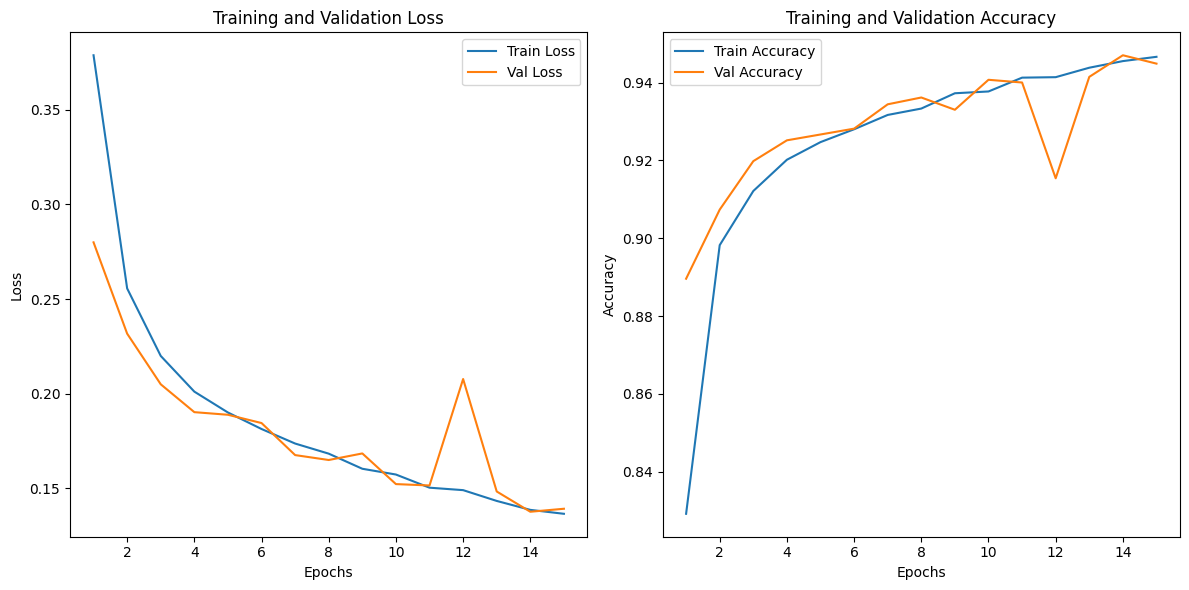

In [67]:
import matplotlib.pyplot as plt

# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DualBranchCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

# Metrics tracking
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

# Training loop
epochs = 15
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure labels are [B, 1]

        optimizer.zero_grad()

        # Mixed precision forward pass
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

        # Calculate training accuracy
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_cnn_model.pth")
        print("Model saved!")

# Plot training and validation metrics
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-68-6e593e66577f>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_cnn_model.pth"))


Test Accuracy: 94.60%


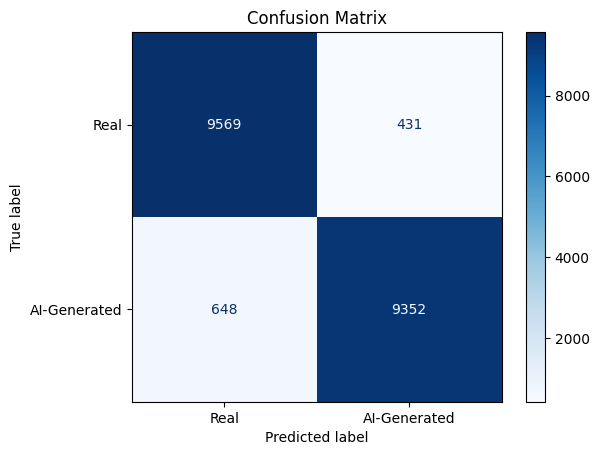

In [68]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualBranchCNN().to(device)
model.load_state_dict(torch.load("best_cnn_model.pth"))
model.eval()  # Set the model to evaluation mode

# Test loop
def evaluate_model(model, test_loader, threshold=0.5):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs) > threshold  # Apply sigmoid and thresholding
            correct += (predictions.squeeze() == labels).sum().item()
            total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return np.array(all_preds), np.array(all_labels)

# Confusion Matrix Plot
def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "AI-Generated"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation
all_preds, all_labels = evaluate_model(model, val_loader)
plot_confusion_matrix(all_labels, all_preds)
